# Global processing

Based partially on

Wrzesien, M. L., Pavelsky, T. M., Durand, M. T., Dozier, J., & Lundquist, J. D. (2019). Characterizing biases in mountain snow accumulation from global data sets. Water Resources Research, 55, 9873–9891. https://doi.org/10.1029/2019WR025350

In [1]:
!pip install -q easysnowdata

In [2]:
import easysnowdata
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask_gateway

In [3]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(50)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.b5474a616a804efdb2aa70f7b08327e4/status


Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.11/ssl.py", line 1382, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 202, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tornado/iostream.py", line 691, in _handle_events
    self._h

## To save time, let's only process MODIS tiles with land in them! 
## Check out MODIS's grid system: https://modis-land.gsfc.nasa.gov/MODLAND_grid.html

In [ ]:
modis_grid = gpd.read_file('zip+http://book.ecosens.org/wp-content/uploads/2016/06/modis_grid.zip!modis_sinusoidal_grid_world.shp')
land = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
land_modis_crs = gpd.GeoSeries(land.unary_union,crs='EPSG:4326').to_crs(modis_grid.crs)
modis_grid_land_idx = modis_grid.intersects(land_modis_crs.unary_union)
modis_grid_land = modis_grid[modis_grid_land_idx]
modis_grid_not_land = modis_grid[~modis_grid_land_idx]

In [ ]:
f,ax=plt.subplots(figsize=(15,15))
land_modis_crs.plot(ax=ax,color='green')
modis_grid_not_land.geometry.boundary.plot(ax=ax,color='gray',linewidth=0.5)
modis_grid_land.geometry.boundary.plot(ax=ax,color='blue',linewidth=2)
modis_grid_land

In [4]:
bbox_gdf = gpd.read_file(
    "https://github.com/egagli/easysnowdata/raw/main/docs/examples/mt_rainier.geojson"
)

In [7]:
modis = easysnowdata.remote_sensing.MODIS_snow(bbox_gdf,clip_to_bbox=False,start_date='2014-10-02',end_date='2023-09-30',data_product="MOD10A2", bands='Maximum_Snow_Extent').data['Maximum_Snow_Extent']

Data retrieved. Access with the .data attribute.


In [8]:
modis

<xarray.DataArray 'Maximum_Snow_Extent' (time: 413, y: 2400, x: 2400)> Size: 2GB
dask.array<Maximum_Snow_Extent, shape=(413, 2400, 2400), dtype=uint8, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 19kB 5.56e+06 5.559e+06 ... 4.448e+06 4.448e+06
  * x            (x) float64 19kB -1.001e+07 -1.001e+07 ... -8.896e+06
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 3kB 2014-09-30 2014-10-08 ... 2023-09-30

In [9]:
modis.coords['WY'] = ("time",pd.to_datetime(modis.time).map(easysnowdata.utils.datetime_to_WY))
modis.coords['DOWY'] = ("time",pd.to_datetime(modis.time).map(easysnowdata.utils.datetime_to_DOWY))

In [10]:
modis

<xarray.DataArray 'Maximum_Snow_Extent' (time: 413, y: 2400, x: 2400)> Size: 2GB
dask.array<Maximum_Snow_Extent, shape=(413, 2400, 2400), dtype=uint8, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 19kB 5.56e+06 5.559e+06 ... 4.448e+06 4.448e+06
  * x            (x) float64 19kB -1.001e+07 -1.001e+07 ... -8.896e+06
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 3kB 2014-09-30 2014-10-08 ... 2023-09-30
    WY           (time) int64 3kB 2014 2015 2015 2015 ... 2023 2023 2023 2023
    DOWY         (time) int64 3kB 365 8 16 24 32 40 ... 325 333 341 349 357 365

In [12]:
def mod10a2_seasonal_snow_mask(da):

    SNOW_VALUE = 200
    CLOUD_VALUE = 50
    NO_SNOW_VALUE = 25

    def mod10a2_wrzesien_cloud_filling(da, SNOW_VALUE=SNOW_VALUE, CLOUD_VALUE=CLOUD_VALUE, NO_SNOW_VALUE=NO_SNOW_VALUE):
        # My implementation of Wrzesien et al. 2019's cloud filling approach... "To allow for cloudy conditions during periods of snow accumulation, we assume that if two snow-covered MOD10A2 observations bracket one or more cloudy MOD10A2 observations, the cloudy period is likely snow covered, too. Following this assumption, we require only the first and last 8-day MOD10A2 observations to be snow covered. That is to say, if we have one snowy MOD10A2 observation, five cloudy MOD10A2 periods, and one snowy observation, we classify the 56-day period as snow covered."
        # this should return binary (0:nosnow, 1:snow), where 1 can be either snow or cloud(s) bracketed by snow
        effective_snow = xr.where((da.where(lambda x: x!=CLOUD_VALUE).ffill(dim='time') == SNOW_VALUE) & (da.where(lambda x: x!=CLOUD_VALUE).bfill(dim='time') == SNOW_VALUE),1,0)
        
        return effective_snow

    effective_snow = mod10a2_wrzesien_cloud_filling(da)

    # Now use this effective_snow to count consecutive snow days
    def get_longest_consec_stretch(arr):
        max_len = 0
        max_start = 0
        max_end = 0
        current_start = None
        for i, val in enumerate(arr):
            if val:
                if current_start is None:
                    current_start = i
            else:
                if current_start is not None:
                    length = i - current_start
                    if length > max_len:
                        max_len = length
                        max_start = current_start
                        max_end = i - 1
                    current_start = None
        if current_start is not None:
            length = len(arr) - current_start
            if length > max_len:
                max_len = length
                max_start = current_start
                max_end = len(arr) - 1
        return max_start, max_end, max_len
    
    # Apply function along the time dimension using the effective snow data
    results = xr.apply_ufunc(
        get_longest_consec_stretch, 
        effective_snow,
        input_core_dims=[['time']],
        output_core_dims=[[], [], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int, int, int]
    )

    substitution_dict = {index: value for index, value in enumerate(da.DOWY.values)}

    def map_values(value):
        return np.vectorize(substitution_dict.get)(value)

    snow_start_DOWY = xr.apply_ufunc(
        map_values,
        results[0],
        vectorize=True,  # This allows for the function to apply element-wise
        dask='parallelized'
    )
    snow_end_DOWY = xr.apply_ufunc(
        map_values,
        results[1],
        vectorize=True,  # This allows for the function to apply element-wise
        dask='parallelized'
    )
    
    snow_mask = xr.Dataset({
        'SAD_DOWY': snow_start_DOWY.astype(np.int16),
        'SDD_DOWY': snow_end_DOWY.astype(np.int16)+8,
        'max_consec_snow_days': results[2].astype(np.int16)*8
    })

    return snow_mask

In [13]:
modis_mask = modis.chunk(dict(time=-1)).groupby('WY').apply(mod10a2_seasonal_snow_mask).compute()

In [15]:
modis_mask

<xarray.Dataset> Size: 346MB
Dimensions:               (y: 2400, x: 2400, WY: 10)
Coordinates:
  * y                     (y) float64 19kB 5.56e+06 5.559e+06 ... 4.448e+06
  * x                     (x) float64 19kB -1.001e+07 -1.001e+07 ... -8.896e+06
    spatial_ref           int32 4B 0
  * WY                    (WY) int64 80B 2014 2015 2016 2017 ... 2021 2022 2023
Data variables:
    SAD_DOWY              (WY, y, x) int16 115MB 365 365 365 365 ... 88 88 88 88
    SDD_DOWY              (WY, y, x) int16 115MB 373 373 373 373 ... 157 157 157
    max_consec_snow_days  (WY, y, x) int16 115MB 0 0 0 0 0 0 ... 56 56 56 56 56

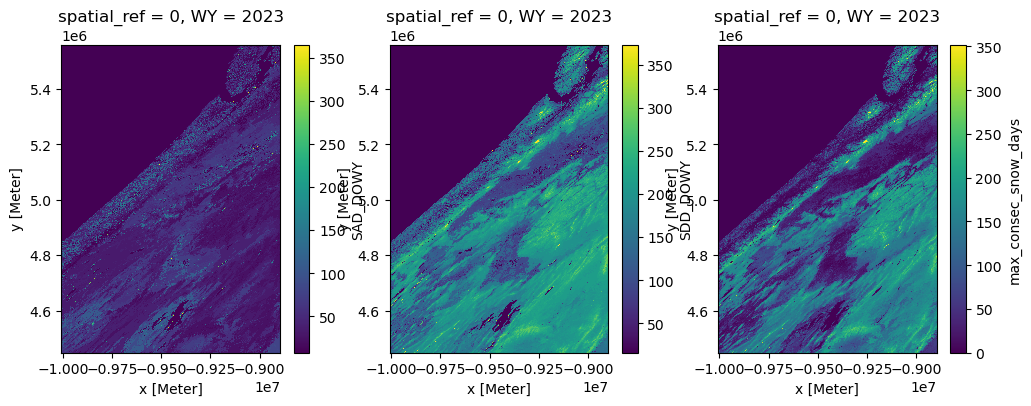

In [16]:
f,ax=plt.subplots(1,3,figsize=(12,4))
modis_mask['SAD_DOWY'].sel(WY=2023).plot(ax=ax[0])
modis_mask['SDD_DOWY'].sel(WY=2023).plot(ax=ax[1])
modis_mask['max_consec_snow_days'].sel(WY=2023).plot(ax=ax[2])

In [17]:
modis_mask.nbytes/1E9

0.345638484

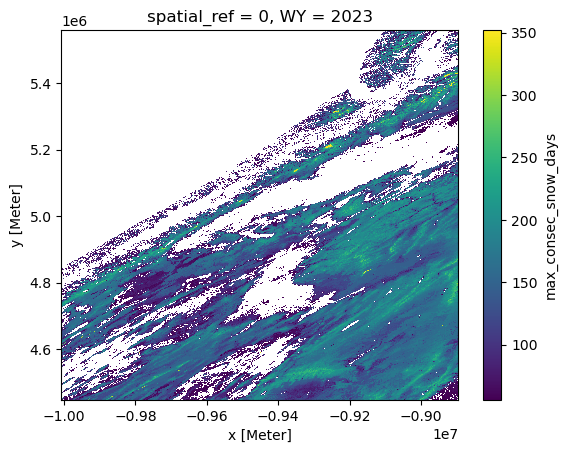

In [20]:
modis_mask.sel(WY=2023)['max_consec_snow_days'].where(lambda x: x>=56).plot()

/tmp/ipykernel_559/2929076525.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  land = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

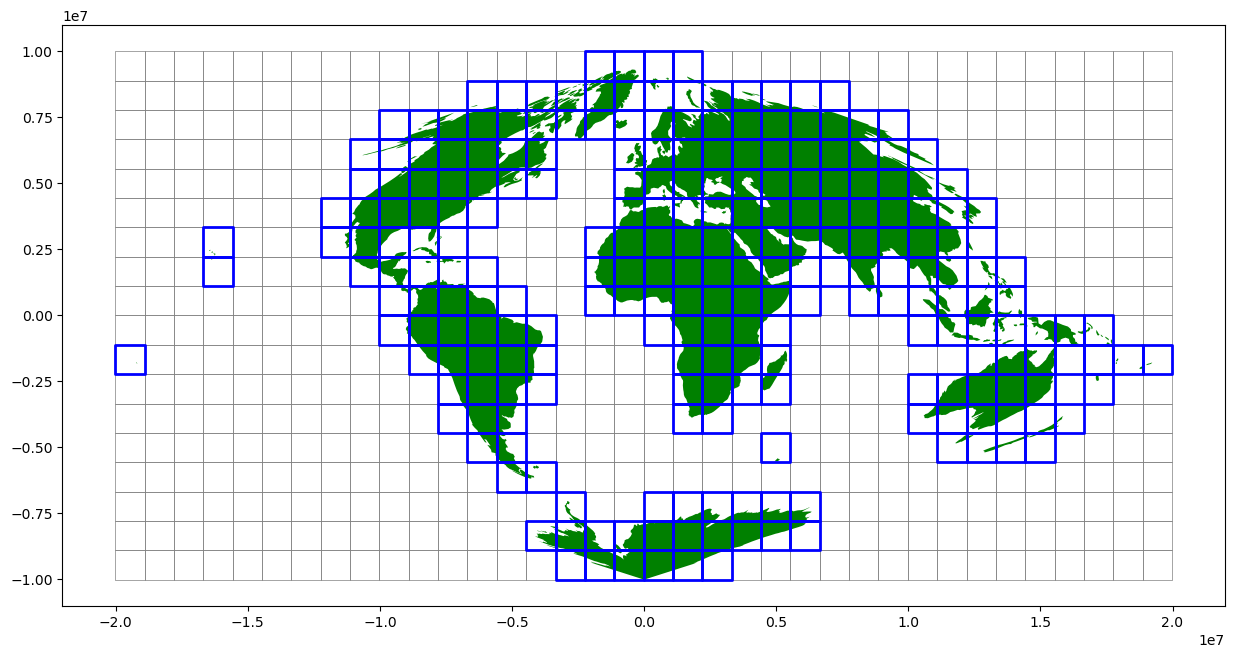

,cat,h,v,geometry
15,16,15,17,"POLYGON ((-2982964.667 -10010000.000, -3353335..."
16,17,16,17,"POLYGON ((-1871853.667 -10010000.000, -2242224..."
17,18,17,17,"POLYGON ((-760742.667 -10010000.000, -1131113...."
18,19,18,17,"POLYGON ((350368.333 -10010000.000, -20002.000..."
19,20,19,17,"POLYGON ((1461479.333 -10010000.000, 1091109.0..."
...,...,...,...,...
600,601,24,1,"POLYGON ((7017034.333 7767776.000, 6646664.000..."
628,629,16,0,"POLYGON ((-1871853.667 8878887.000, -2242224.0..."
629,630,17,0,"POLYGON ((-760742.667 8878887.000, -1131113.00..."
630,631,18,0,"POLYGON ((350368.333 8878887.000, -20002.000 8..."


In [31]:
import pystac_client
import planetary_computer
product= "MOD10A2"
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [34]:
search = catalog.search(
    collections=[f"modis-{product[3:]}-061"],
    bbox=bbox_gdf.total_bounds,
    datetime=('2020-01-01', '2020-01-01'),
    
)

In [36]:
search.get_all_items()

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:849: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [49]:

search = catalog.search(
    collections=[f"modis-{product[3:]}-061"],
    bbox=bbox_gdf.total_bounds,
    datetime=('2020-01-01', '2020-01-01'),
    query={
        "modis:vertical-tile": {"eq": your_desired_vertical_value},
        "modis:horizontal-tile": {"eq": your_desired_horizontal_value}
    }    
)

search.get_all_items()